# Single DPI Neuron & Synapse Response

In this experiment, we use ``DynapSim`` to investigate the behavior of a DPI synapse and a membrane circuit.

* A single neruon with single excitatory synapse will be simulated.
* A randomly generated poisson spike train with a mean frequency 20 Hz will be given as input
* The activated synaptic current will be read from the record dictioary.
* The resulting membrane voltage will be read from the record dictioary.

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Utils
import jax
import numpy as np
from jax import numpy as jnp
from jax.lax import scan

# Rockpool Imports
from rockpool.timeseries import TSEvent
from rockpool.nn.modules.jax import LinearJax
from rockpool.nn.combinators import Sequential

from rockpool.devices.dynapse import DynapSim
from rockpool.devices.dynapse.simulation import step_pwl
from utils import poisson_spike_train, plot_Ix, split_yaxis

# - Plotting and config
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [5.6, 2.8]
plt.rcParams['figure.dpi'] = 1200
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = "dejavuserif"
plt.rcParams["font.size"] = 12

## Step 2 : Network Configuration

Using the simulation configuration object, create a dynapse simulator

In [2]:
# --- Input Layer --- #
linear_in = LinearJax(shape=(1, 1), weight=np.array([.1]), has_bias=False)
linear_in


LinearJax  with shape (1, 1)

In [3]:
dynapsim = DynapSim(1, has_rec=False)

In [4]:
model = Sequential(linear_in, dynapsim)
model

JaxSequential  with shape (1, 1) {
    LinearJax '0_LinearJax' with shape (1, 1)
    DynapSim '1_DynapSim' with shape (1, 1)
}

## Step 3 : Input Spike Train

Generate a random poisson spike train with mean frequency 20 Hz

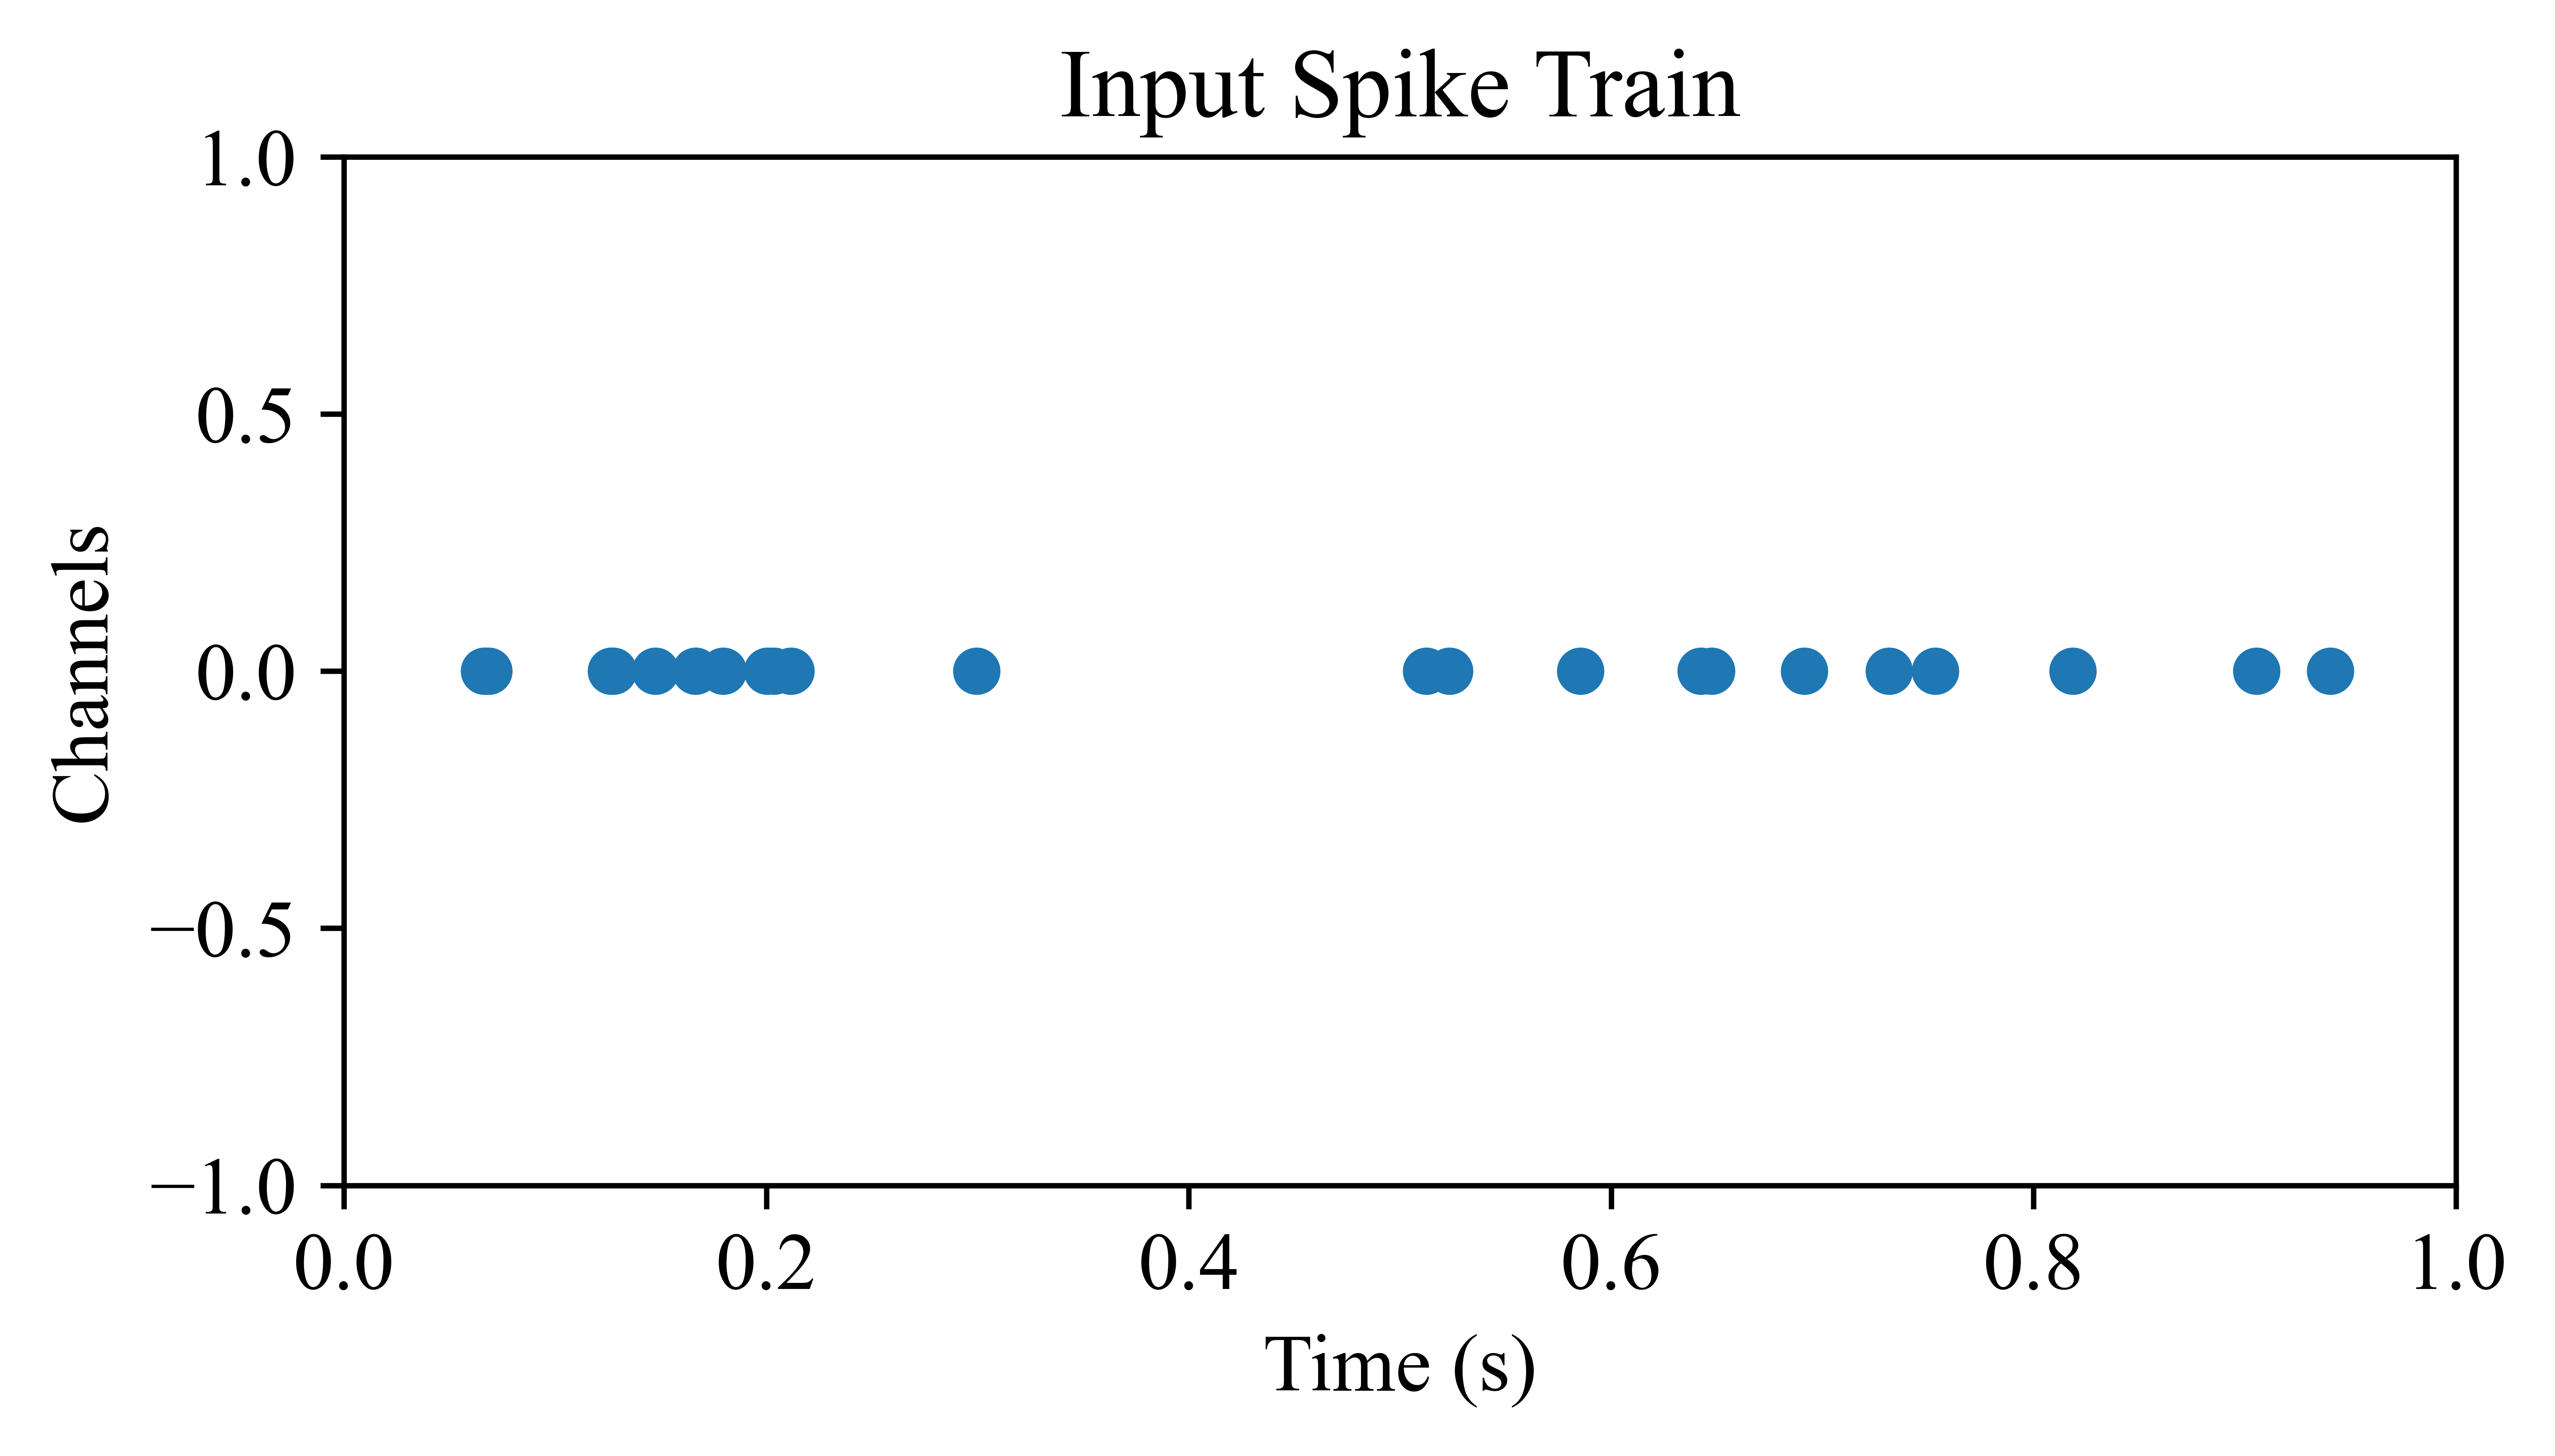

In [5]:
dt = 1e-3
spike_raster = poisson_spike_train(n_channels=1, duration=1.0, rate=20.0, dt=dt, seed=2022).astype(bool)
spike_ts_in = TSEvent.from_raster(spike_raster[0], dt=dt, name="Input Spike Train");
spike_ts_in.plot();

## Step 4 : Run the simulation

Run the network recording the intermediate current reponses

In [6]:
model.reset_state()
out, state, record_dict = model(spike_raster, record=True)


# Step 5 : Analyze the results

Get the AMPA response from record dictionary, plot and save the figure.

In [7]:
spike_ts_out = TSEvent.from_raster(out[0], dt=dt, name="Output Spike Train")

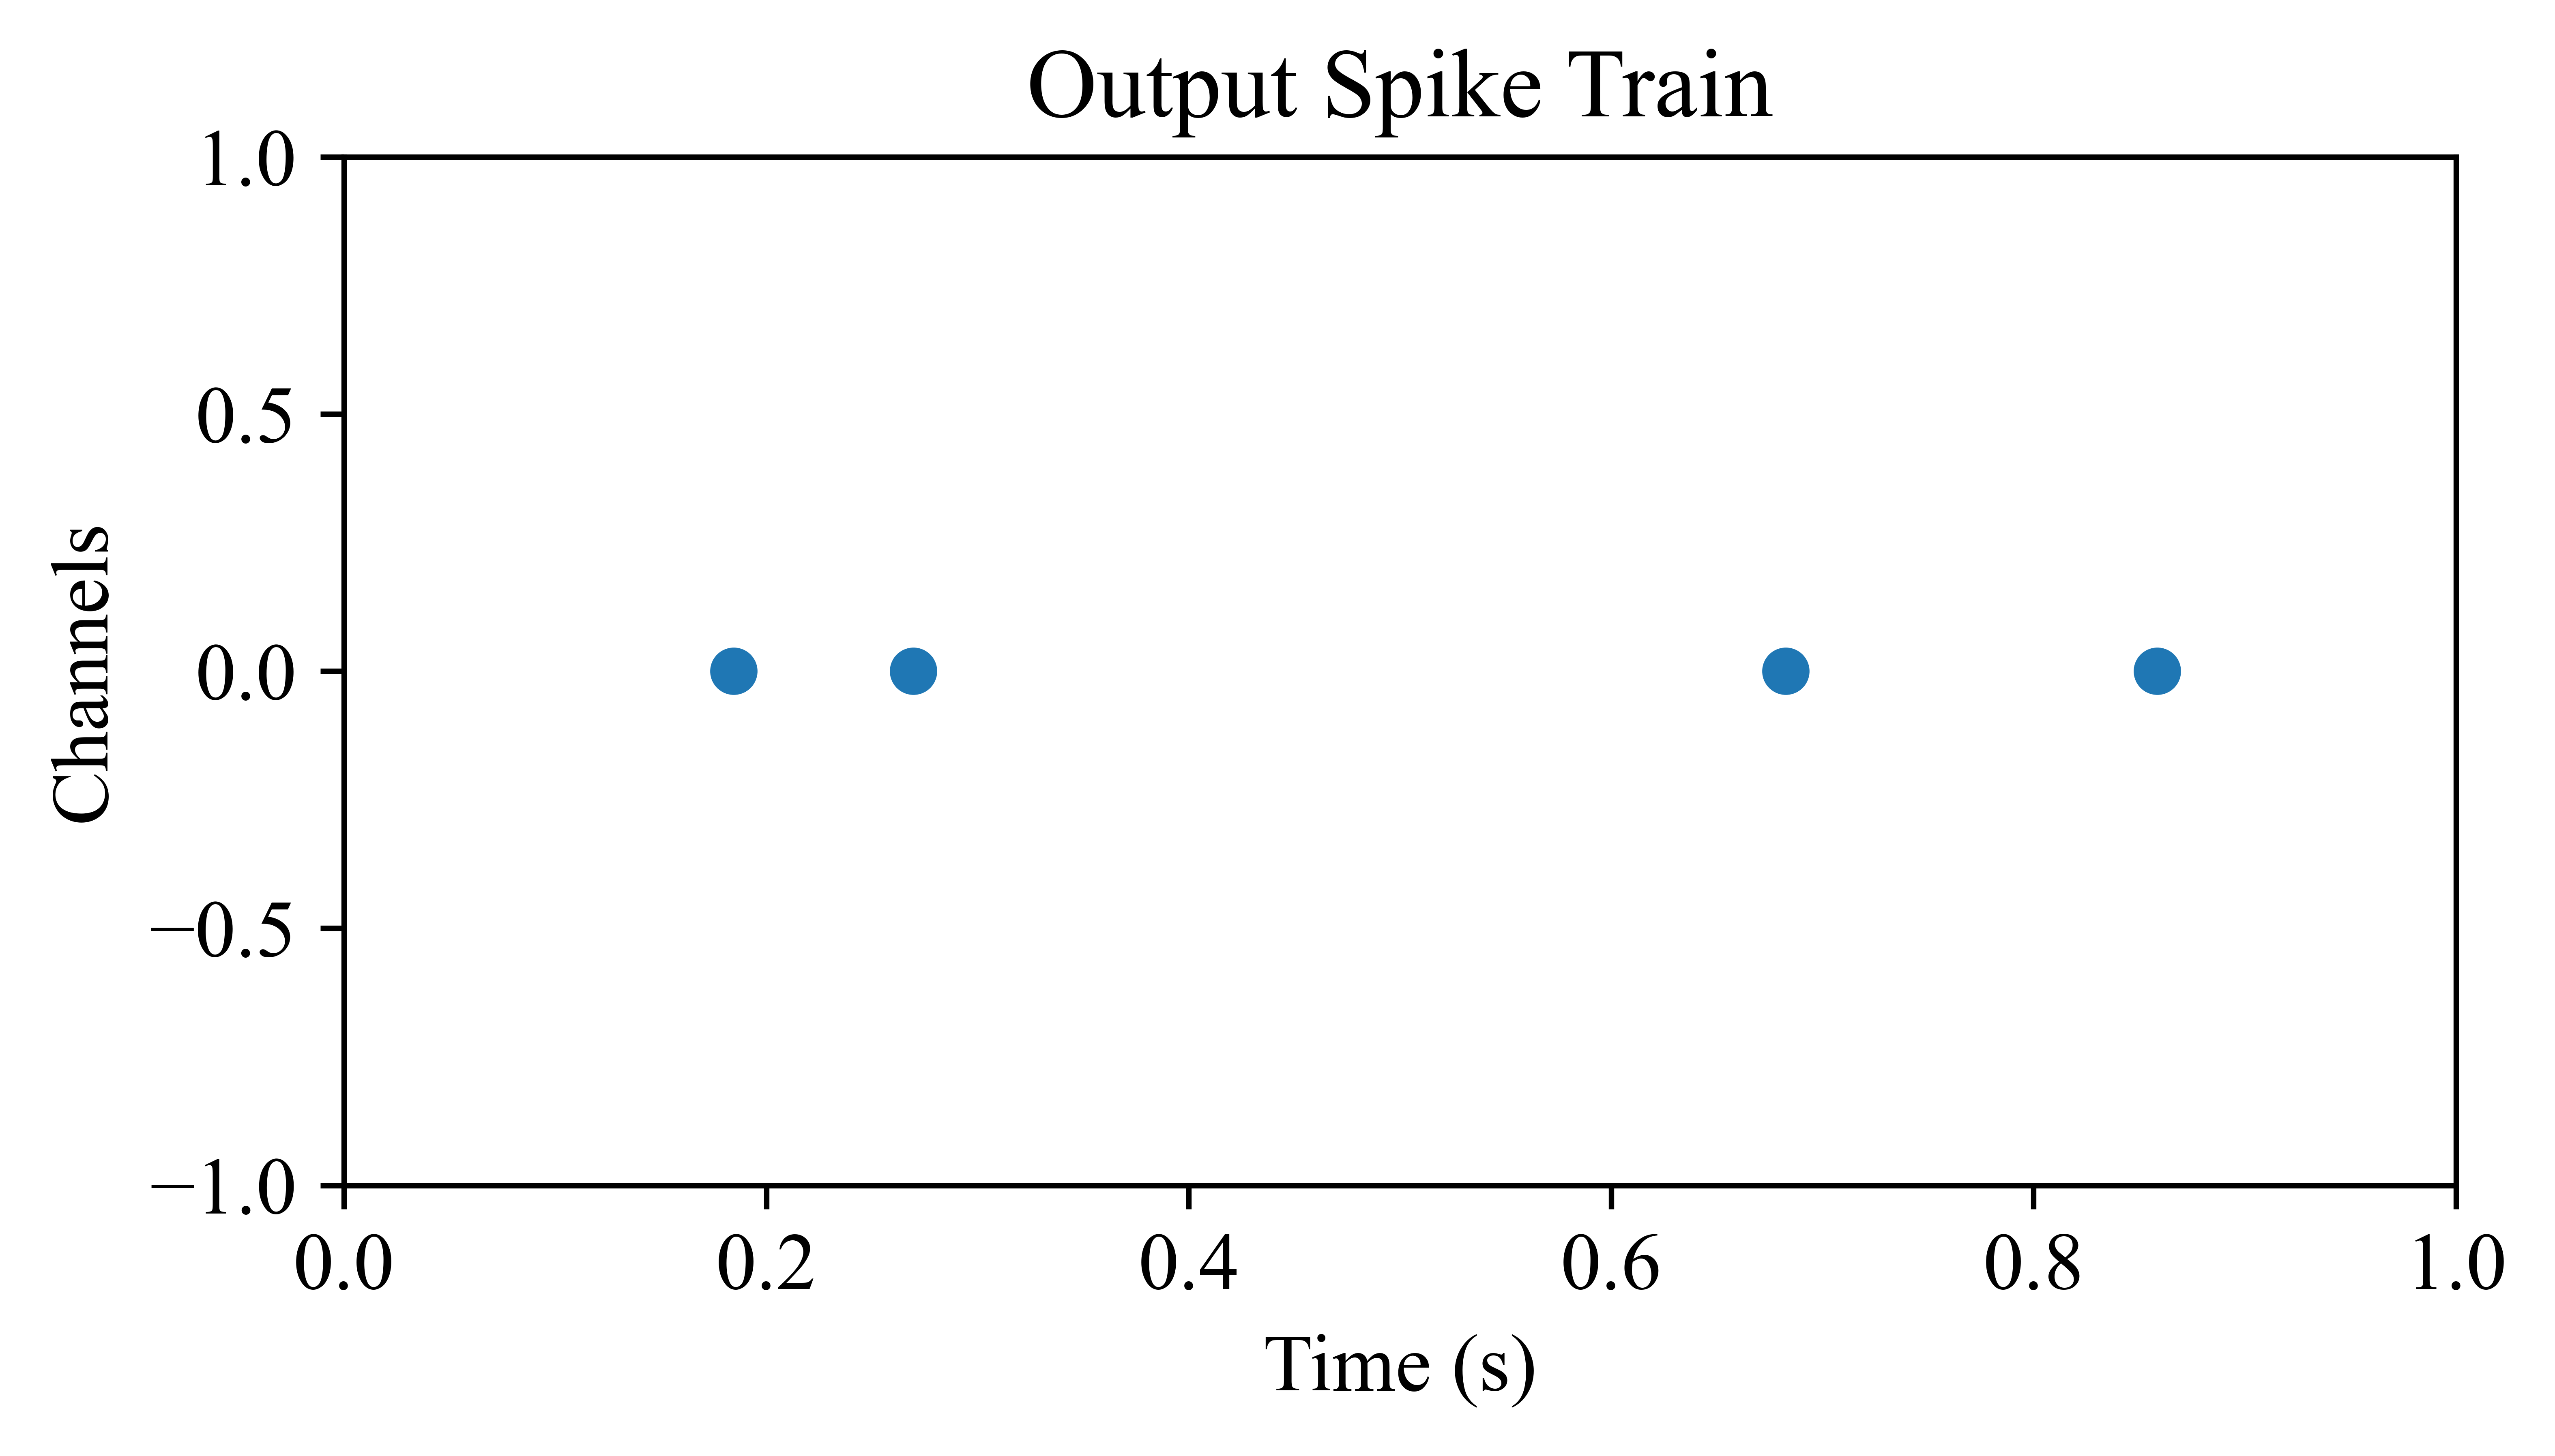

In [8]:
spike_ts_out.plot();

## Step 5.1 : Synaptic Current Repsonse

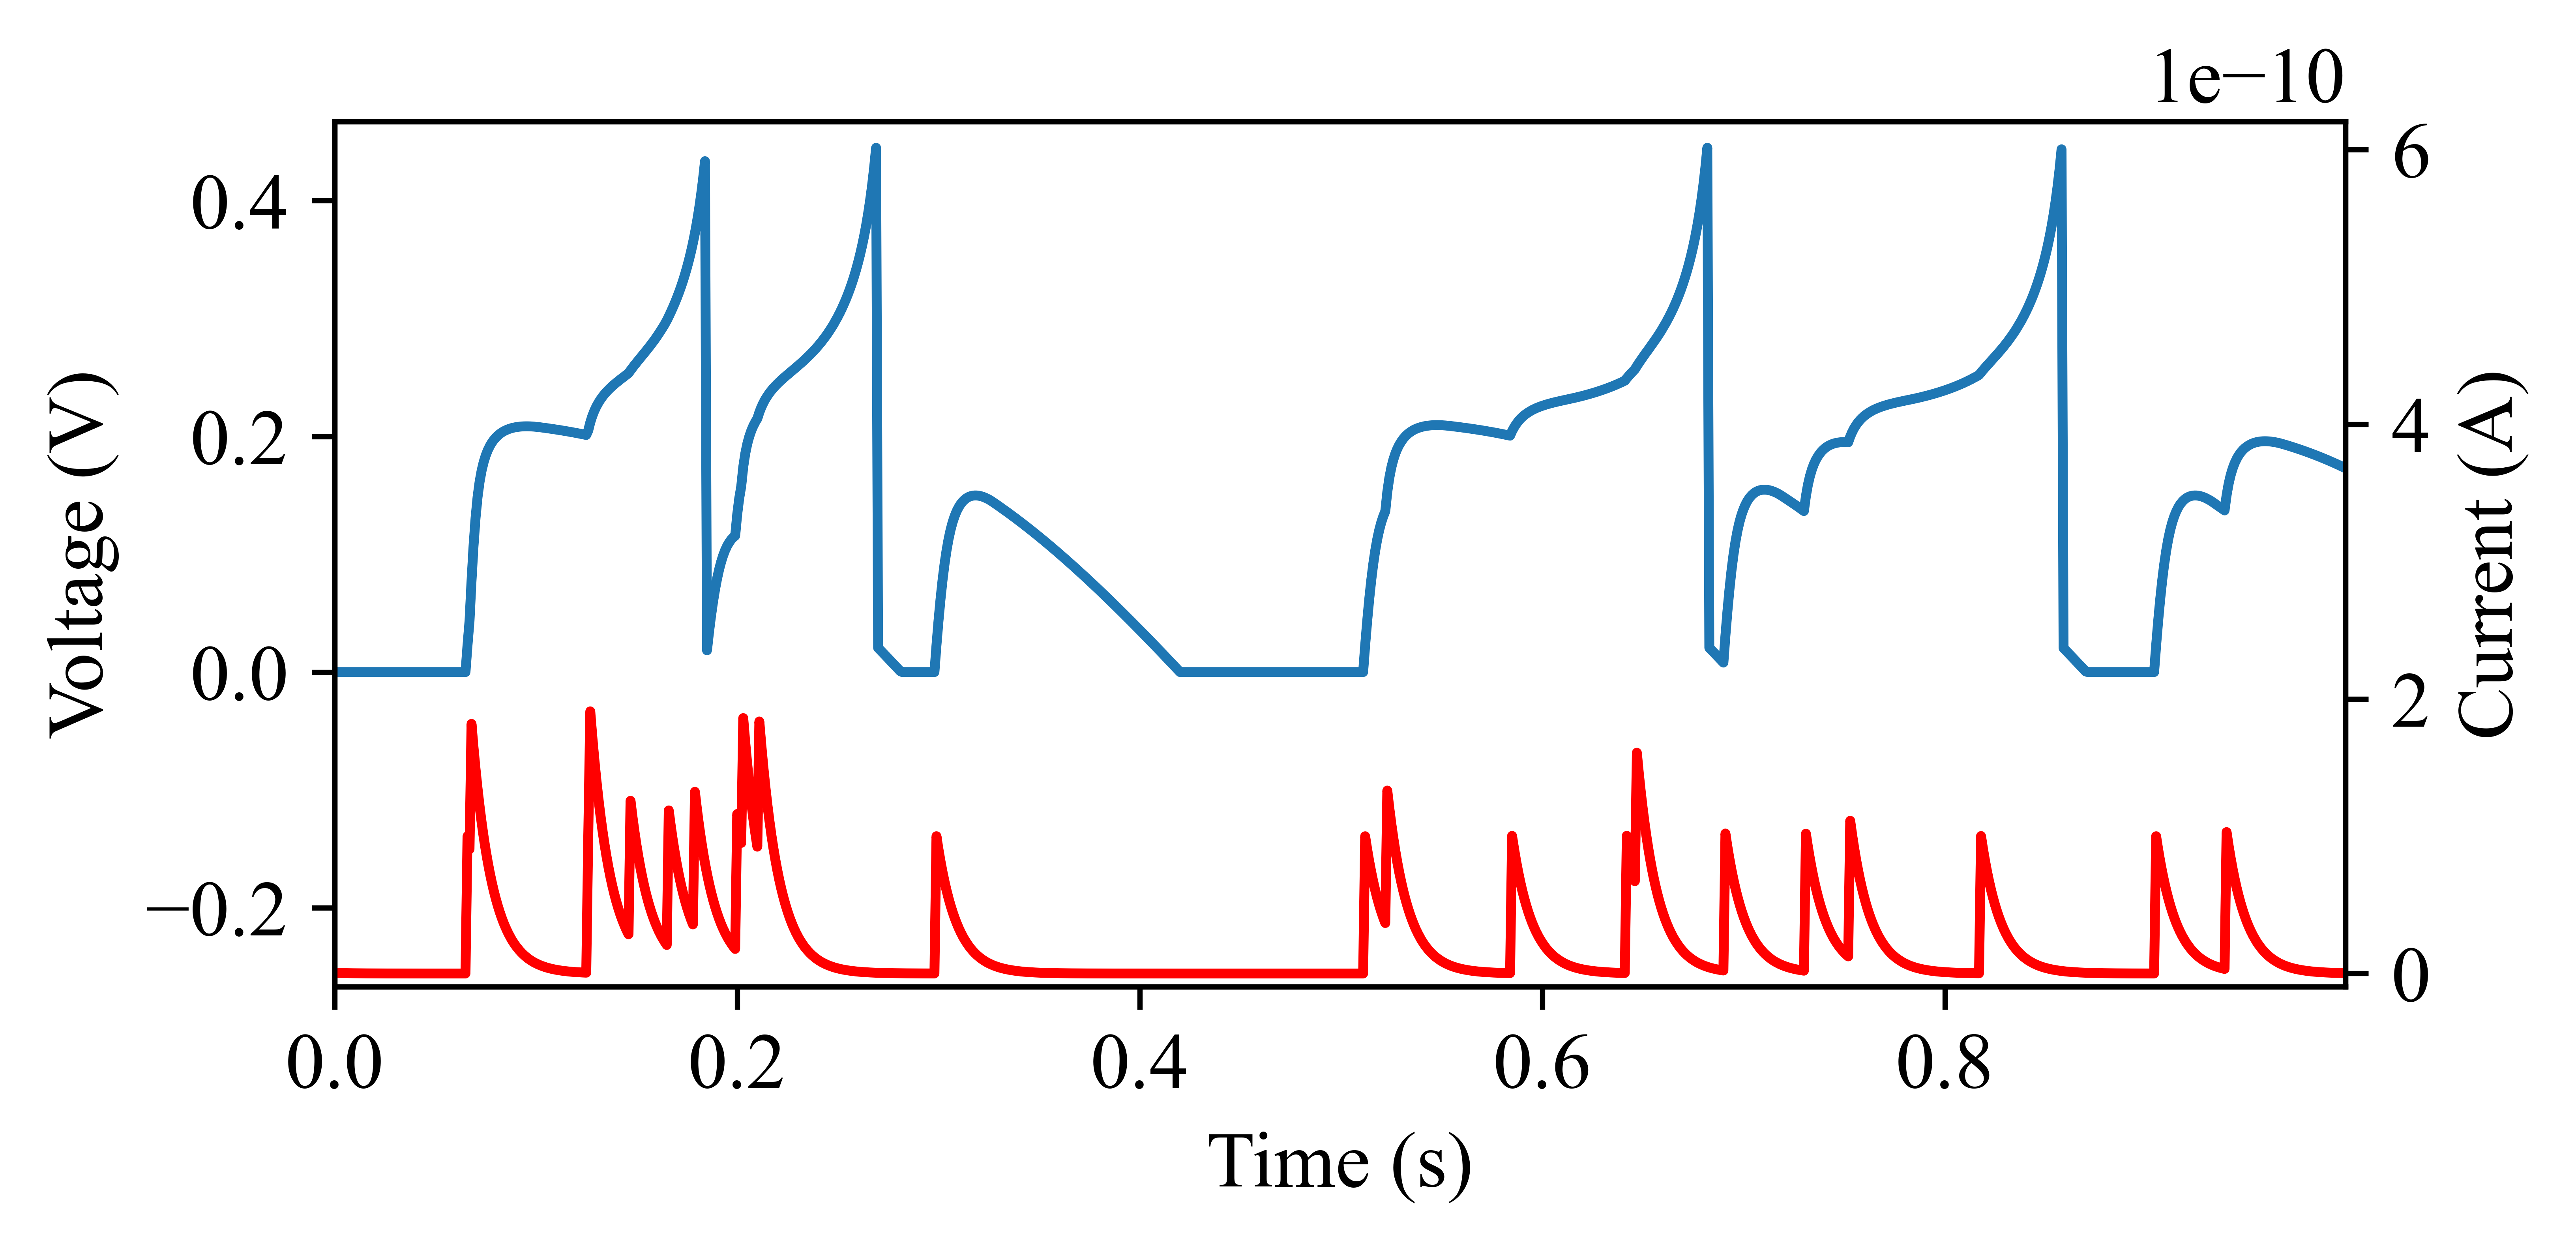

In [9]:
# Plot the vmem and isyn on the same figure
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plot_Ix(record_dict["1_DynapSim"]["vmem"][0], ylabel = "Voltage (V)", ax=ax1, label="$V_{mem}$")
plot_Ix(record_dict["1_DynapSim"]["isyn"][0], ax=ax2, color="red", label="$I_{syn}$")
split_yaxis(ax1, ax2, (2,1))
plt.tight_layout()


# Step 7 : Spike Generation

In [10]:
Ispkthr = 1e-6
Ireset = 5e-13
max_spikes_per_dt = jnp.inf
_min = -14
_max = -3
xs = jnp.logspace(_min,_max,num=10000)

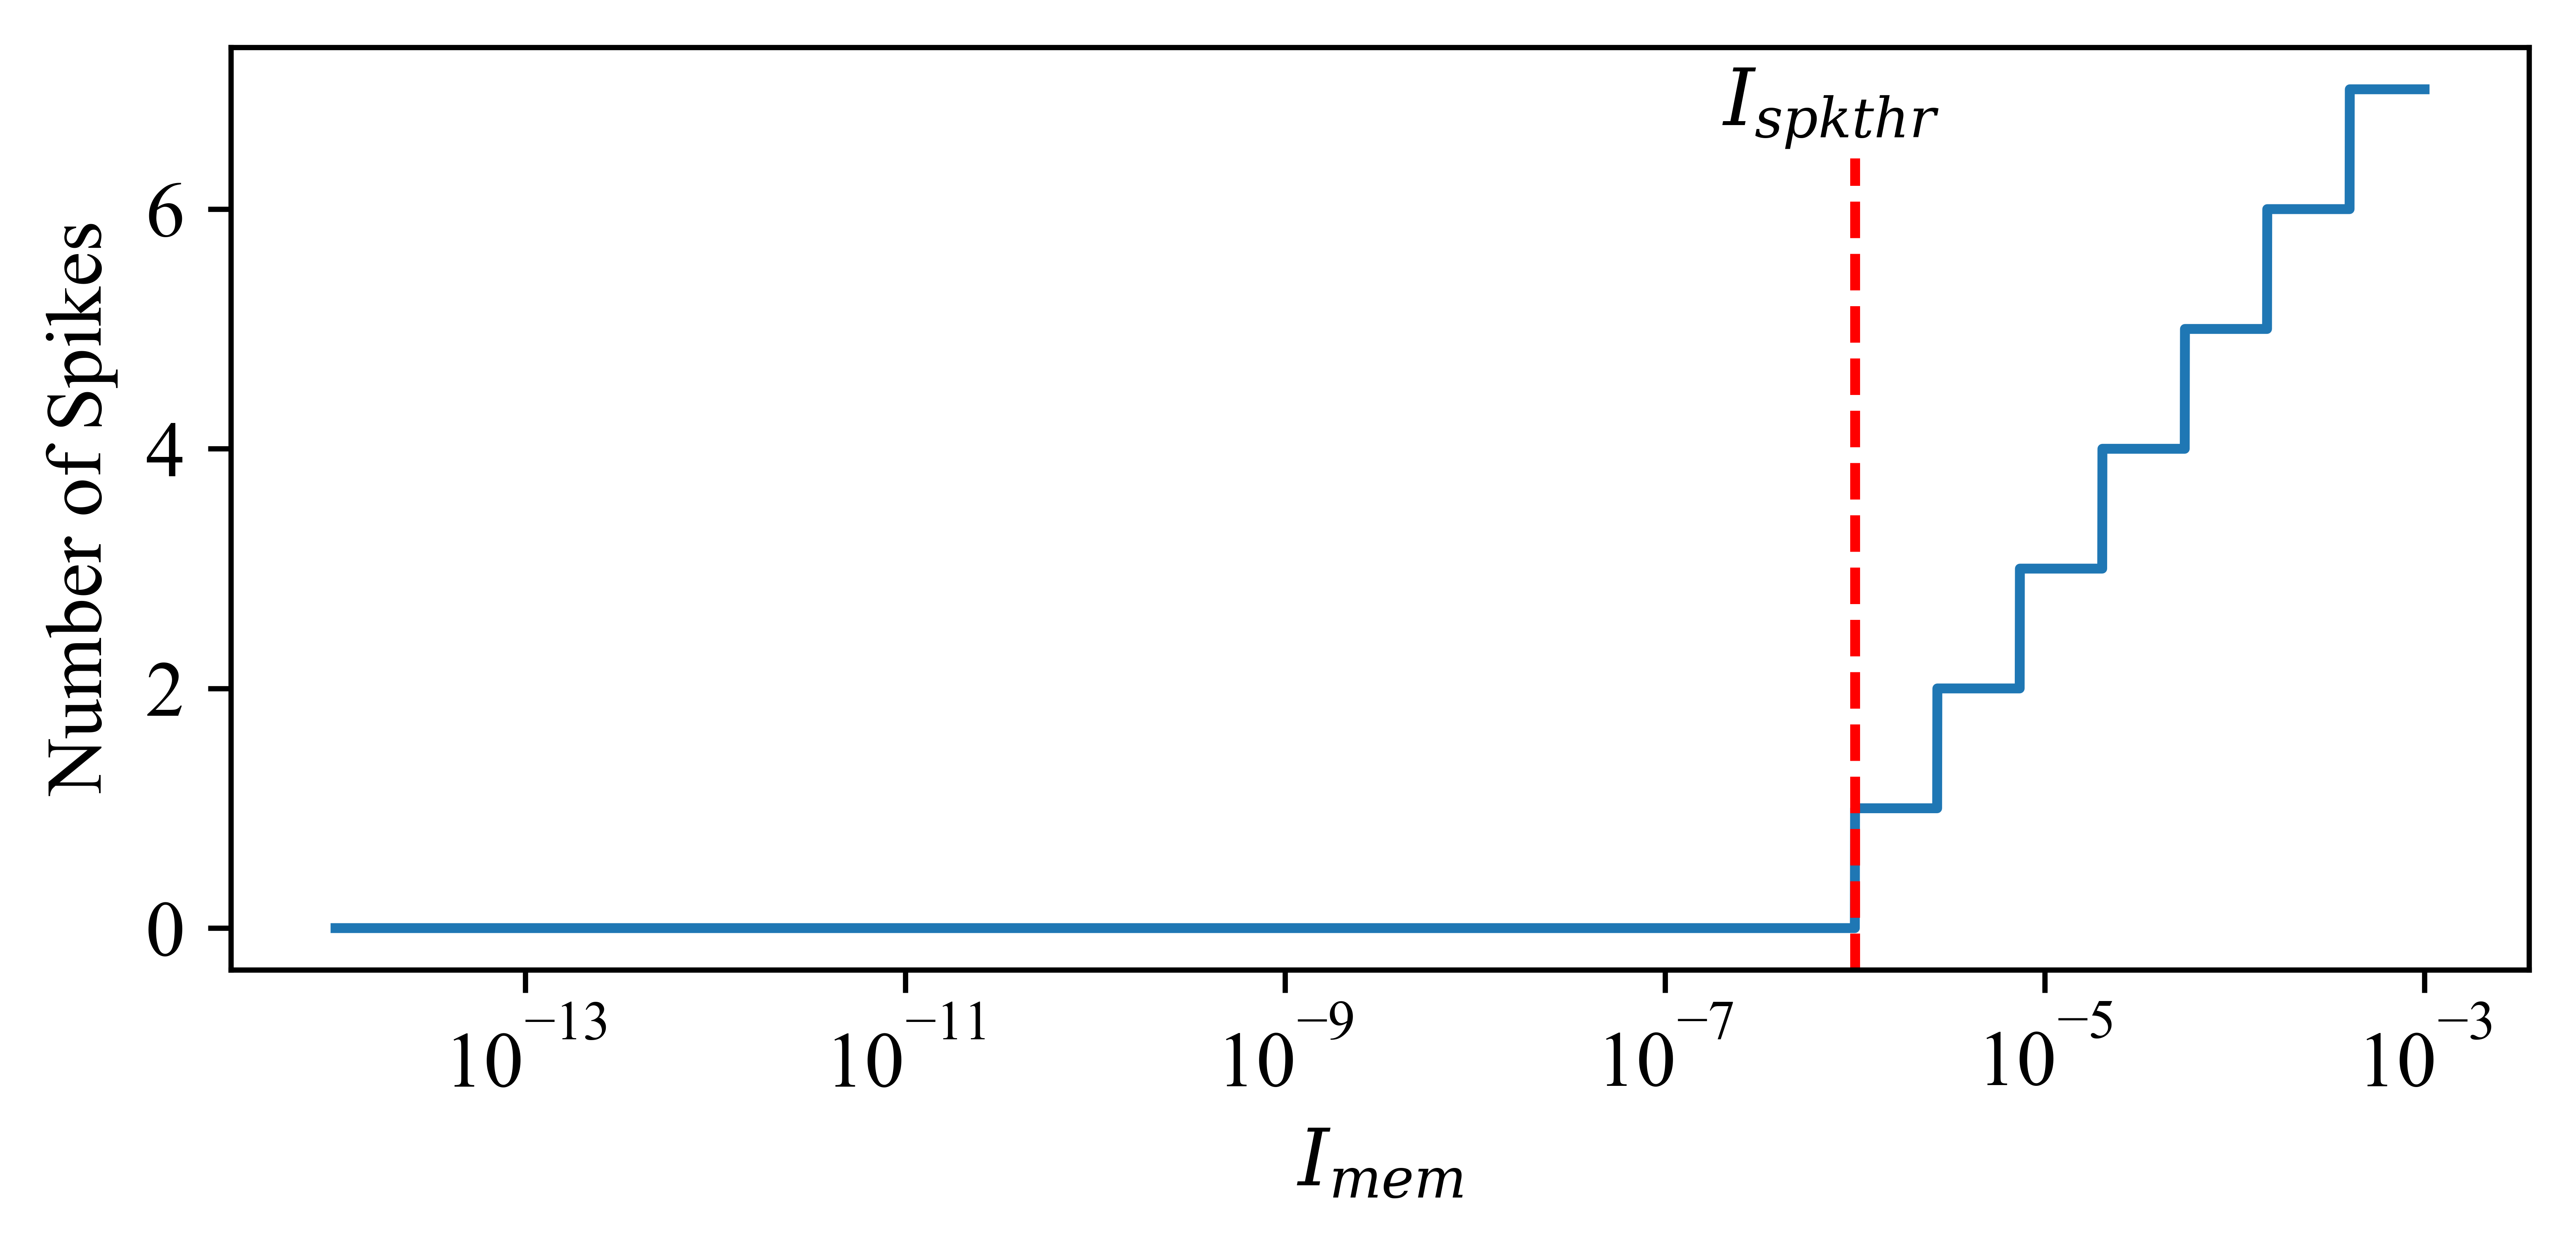

In [11]:
def iterate(state, input):
    Ispkthr, Ireset, max_spikes_per_dt=state
    output = step_pwl(input, Ispkthr, Ireset, max_spikes_per_dt)
    return state, output

state  = (Ispkthr, Ireset, jnp.inf)
state, out = scan(iterate, state, xs)

fig = plt.figure()
plt.semilogx(xs, out)
plt.axvline(Ispkthr, ymin=0, ymax = 0.88, linestyle="dashed", color = "red")
plt.xlabel("$I_{mem}$")
plt.ylabel("Number of Spikes")
plt.text(2e-7,6.7,'$I_{spkthr}$')
plt.tight_layout()

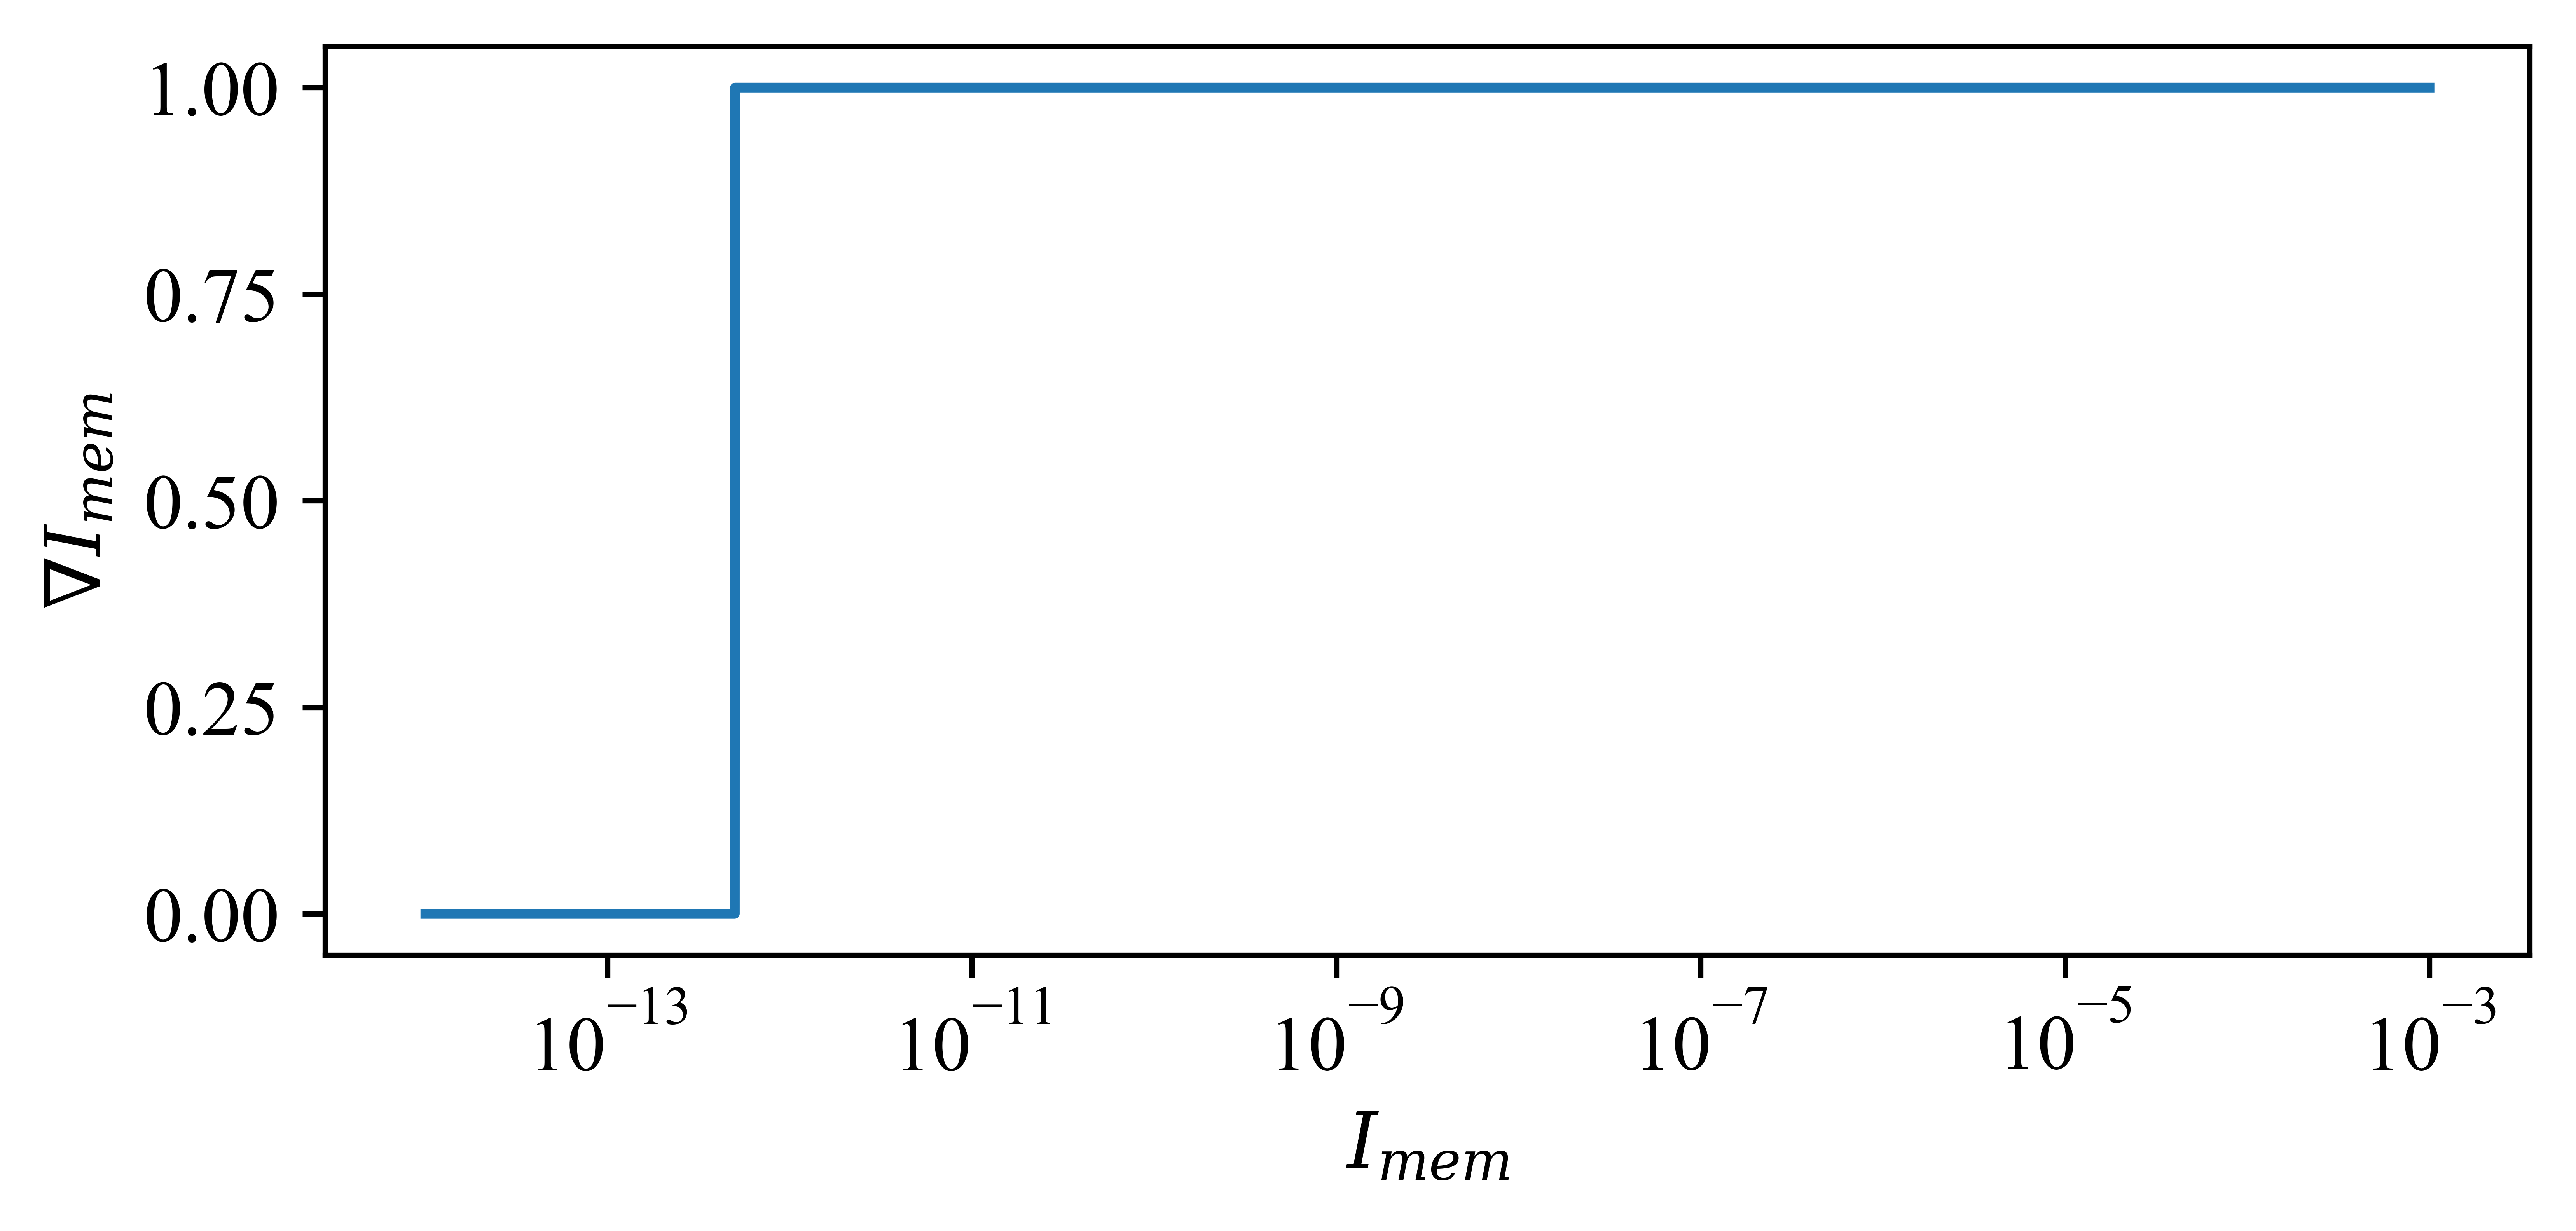

In [12]:
# grad = [jax.grad(step_pwl)(x, 1e-6, 5e-13) for x in xs]

def iterate(state, input):
    Ispkthr, Ireset, max_spikes_per_dt=state
    output = jax.grad(step_pwl)(input, Ispkthr, Ireset, max_spikes_per_dt)
    return state, output


state  = (Ispkthr, Ireset, jnp.inf)
state, grad = scan(iterate, state, xs)
fig = plt.figure()
plt.xlabel("$I_{mem}$")
plt.ylabel("$ \\nabla I_{mem}$")
plt.semilogx(xs, grad)
plt.tight_layout()

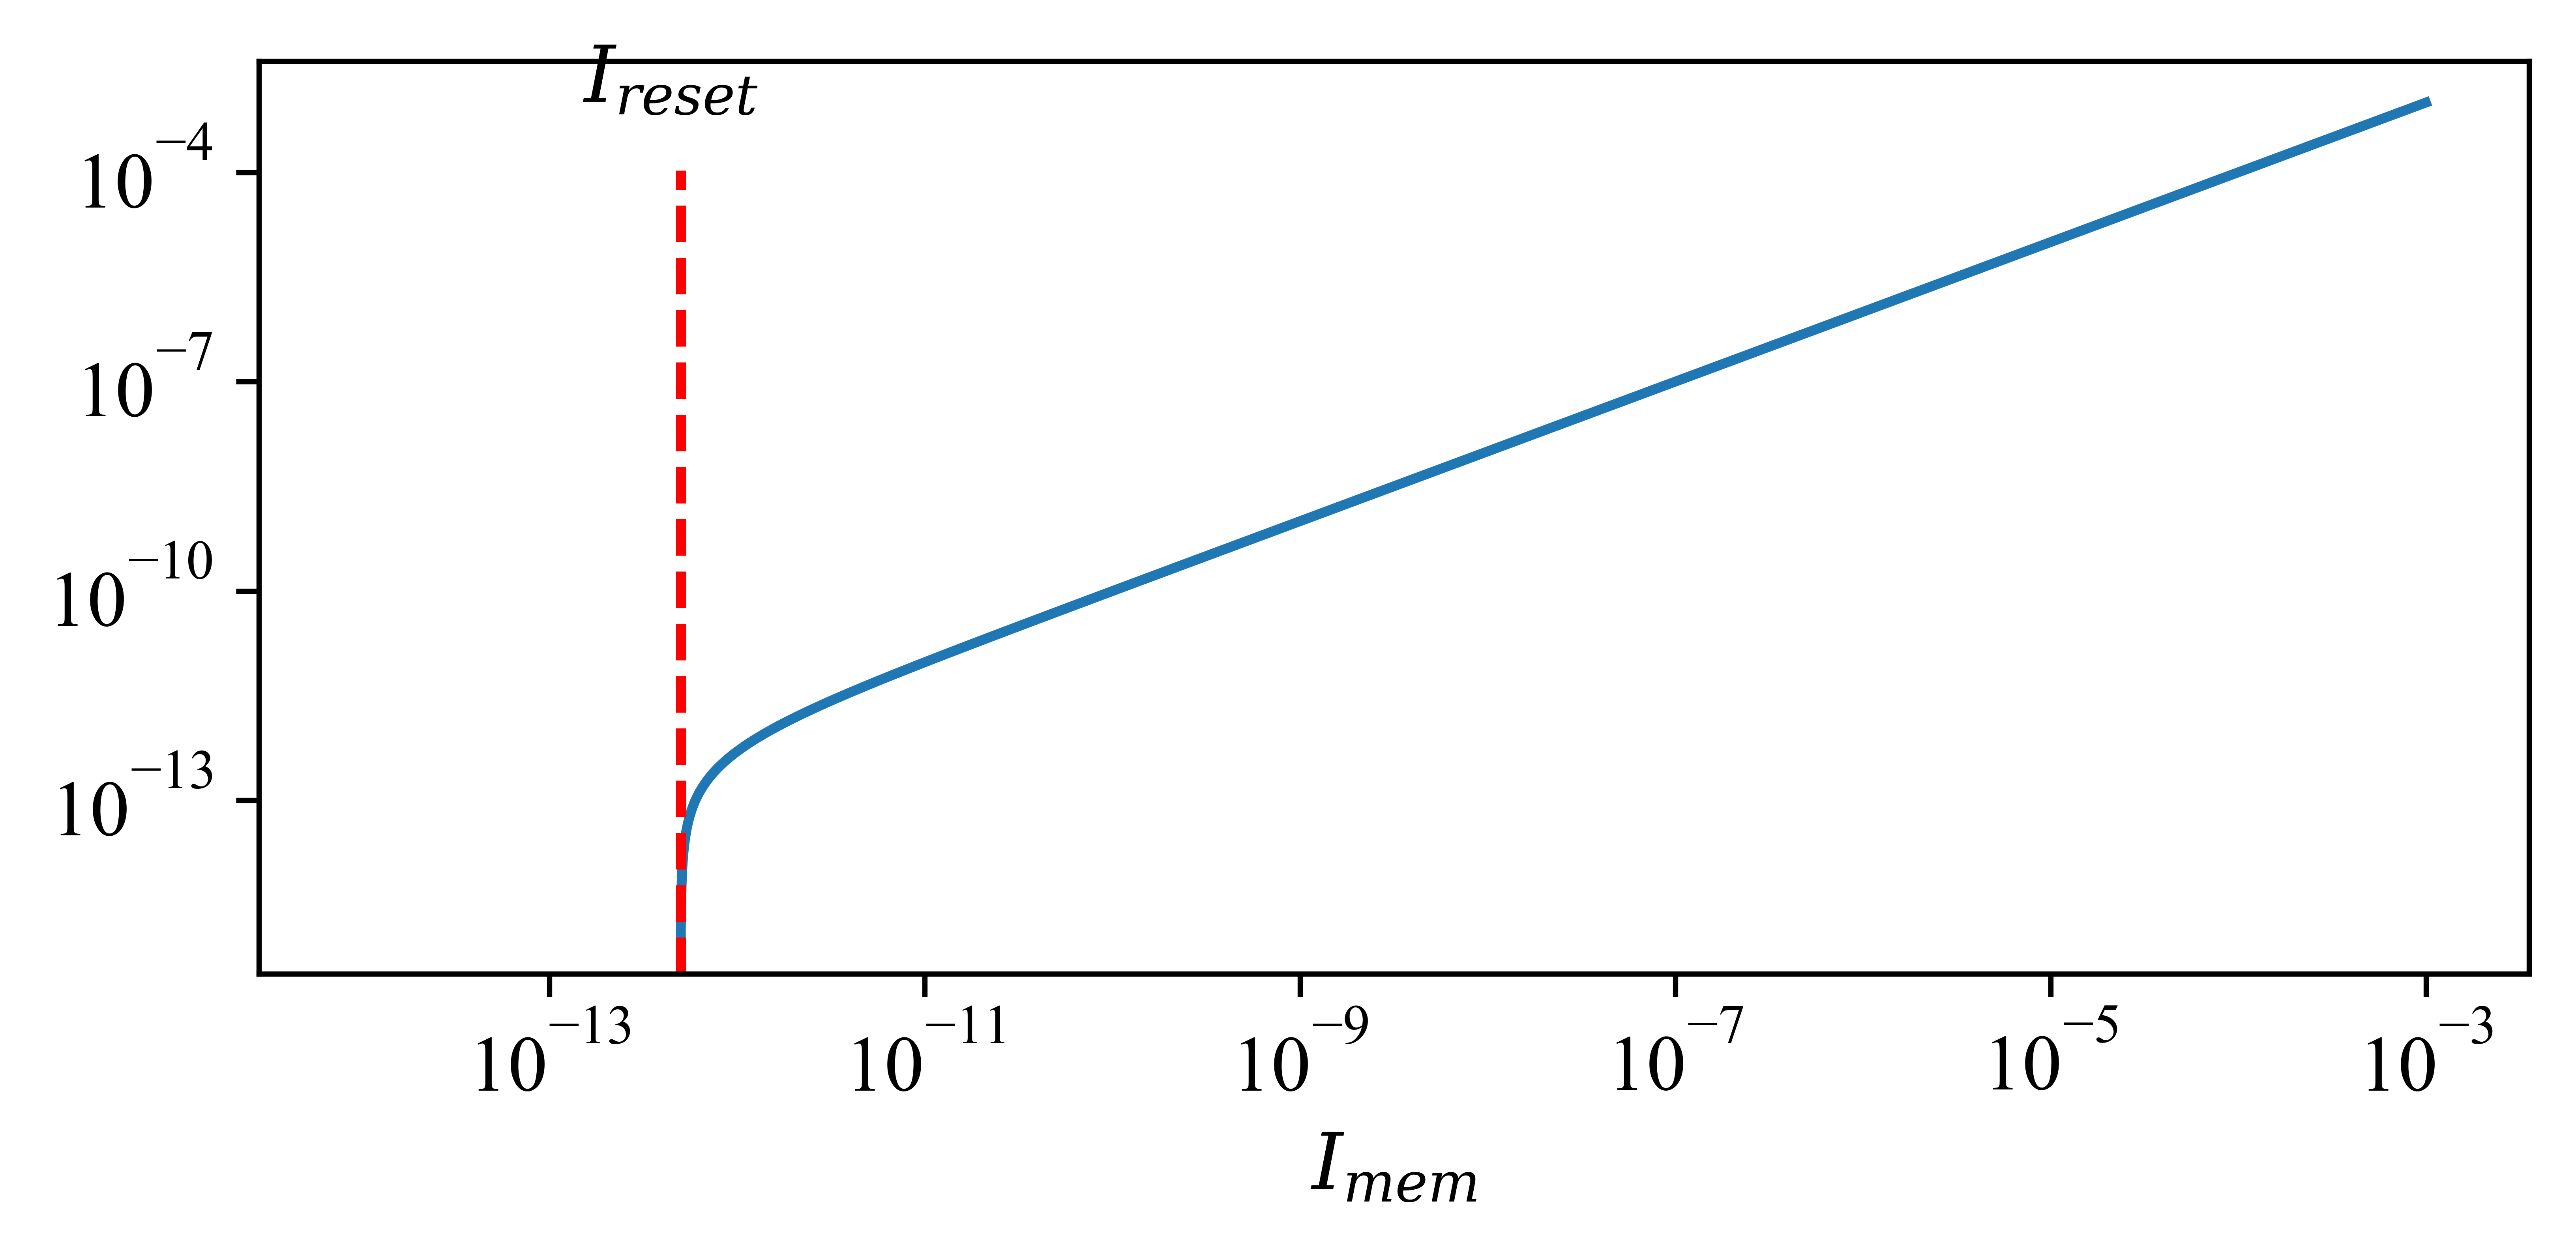

In [13]:
surrogate = jnp.cumsum(grad * jnp.diff(jnp.logspace(_min,_max,num=10001)))
fig = plt.figure()
plt.loglog(xs, surrogate)
plt.axvline(Ireset, ymin=0, ymax = 0.88, linestyle="dashed", color = "red")
plt.text(15e-14,1e-3,'$I_{reset}$')
plt.xlabel("$I_{mem}$")
plt.tight_layout()